In [18]:
import argparse
import logging
import math
import os
import random
from pathlib import Path
from typing import Optional

import accelerate
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from datetime import timedelta
from accelerate.utils import ProjectConfiguration, set_seed, InitProcessGroupKwargs
from datasets import load_dataset
from huggingface_hub import HfFolder, Repository, create_repo, whoami
from packaging import version
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import PretrainedConfig, CLIPTextModel, CLIPTokenizer, CLIPImageProcessor

import diffusers
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    StableDiffusionControlNetPipeline,
    UNet2DConditionModel,
    PNDMScheduler
)

from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

In [19]:
def encode_prompt(tokenizer, text_encoder, prompt, device):
    text_inputs = tokenizer(prompt, padding="max_length", 
                            max_length=tokenizer.model_max_length, truncation=True, 
                            return_tensors="pt",
                            )
    text_input_ids = text_inputs.input_ids

    if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
        attention_mask = text_inputs.attention_mask.to(device)
    else:
        attention_mask = None

    prompt_embeds = text_encoder(
        text_input_ids.to(device),
        attention_mask=attention_mask,
    )
    prompt_embeds = prompt_embeds[0]
    prompt_embeds = prompt_embeds.to(dtype=text_encoder.dtype, device=device)

    uncond_tokens = [""]
    max_length = prompt_embeds.shape[1]
    uncond_input = tokenizer(
        uncond_tokens,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
    )
    if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
        attention_mask = uncond_input.attention_mask.to(device)
    else:
        attention_mask = None
    
    negative_prompt_embeds = text_encoder(
        uncond_input.input_ids.to(device),
        attention_mask=attention_mask,
    )
    negative_prompt_embeds = negative_prompt_embeds[0]

    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

    return prompt_embeds

def decode_latents(vae, latents):
    latents = 1 / vae.config.scaling_factor * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    return image

def prepare_mel(conditioning_mel_path, device):

    conditioning_mel = np.load(conditioning_mel_path)

    conditioning_mel_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BILINEAR),
        ]
    )
    conditioning_mel = conditioning_mel_transforms(conditioning_mel).repeat_interleave(3, dim=0)
    c, h, w = conditioning_mel.shape
    conditioning_mel = conditioning_mel.reshape(1, c, h, w)
    conditioning_mel = conditioning_mel.to(device=device)
    conditioning_mel = torch.cat([conditioning_mel] * 2)
    return conditioning_mel

def inference_mel_to_img(vae: AutoencoderKL, text_encoder: CLIPTextModel, tokenizer: CLIPTokenizer,
                         unet: UNet2DConditionModel, controlnet: ControlNetModel, scheduler: PNDMScheduler,
                        conditioning_mel_path, prompt, num_inference_steps=50, guidance_scale=7.5,
                        device=torch.device("cuda:2")):
    
    print("Device:", device)
    vae.to(device)
    text_encoder.to(device)
    unet.to(device)
    controlnet.to(device)
    vae.requires_grad_(False)
    unet.requires_grad_(False)
    text_encoder.requires_grad_(False)
    controlnet.requires_grad_(False)

    with torch.no_grad(): 
        prompt_embeds = encode_prompt(tokenizer, text_encoder, prompt, device)
        print(prompt_embeds.shape)
        conditioning_mel = prepare_mel(conditioning_mel_path, device)

        scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = scheduler.timesteps

        num_channels_latents = unet.in_channels
        shape = (1, num_channels_latents, 512 // 8, 512 // 8)
        latents = torch.randn(shape, device=device)
        latents = latents.to(device)

        # num_warmup_steps = len(timesteps) - num_inference_steps * scheduler.order
        for t in tqdm(timesteps[:]):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # controlnet(s) inference
            down_block_res_samples, mid_block_res_sample = controlnet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                controlnet_cond=conditioning_mel,
                conditioning_scale=1.0,
                return_dict=False,
            )
            # for res_sample in down_block_res_samples:
            #     print(res_sample.shape)
            # print(mid_block_res_sample.shape)

            # predict the noise residual
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            ).sample

            # perform guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample

        images = decode_latents(vae, latents)
        images = (images * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images[0]

In [20]:
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet")
text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="text_encoder")
tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")

In [29]:
controlnet = ControlNetModel.from_pretrained("/blob/v-yuancwang/DiffAudioImg/AudioControlNet_v1_2/checkpoint-75000")

In [30]:
scheduler = PNDMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

Device: cuda:2
torch.Size([2, 77, 768])


  0%|          | 0/101 [00:00<?, ?it/s]

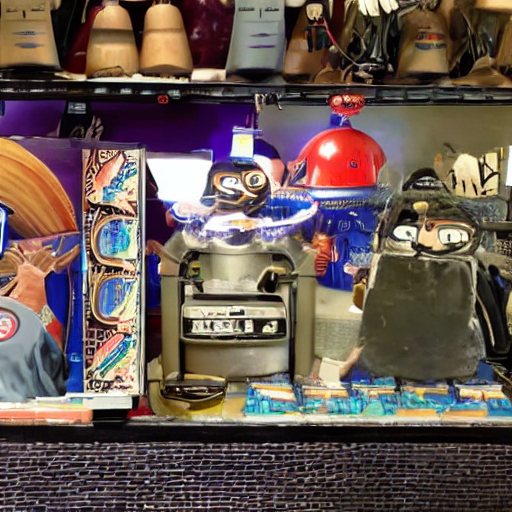

In [34]:
conditioning_mel_path = os.path.join("/blob/v-yuancwang/DiffAudioImg/VGGSound/data/vggsound/mel",
                                     "-7uwQqneg8k_30000_40000.npy")

inference_mel_to_img(vae, text_encoder, tokenizer,
                    unet, controlnet, scheduler,
                    conditioning_mel_path, prompt="", num_inference_steps=100, guidance_scale=7.5,
                    device=torch.device("cuda:2"))

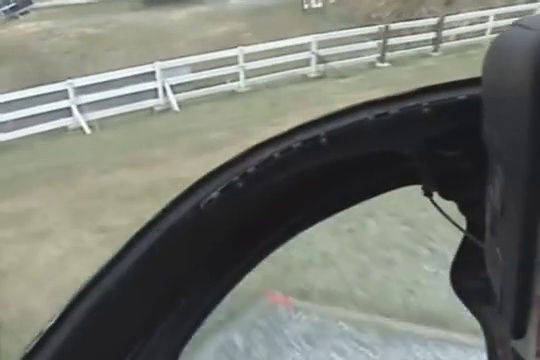

In [37]:
image = Image.open(os.path.join("/blob/v-yuancwang/DiffAudioImg/VGGSound/data/vggsound/img_spilt",
                   "2/-7uwQqneg8k_30000_40000_2.jpg"))
image